In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [8]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [43]:
df_train

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26
...,...,...,...,...,...
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10


## Prophet

In [9]:
import prophet

In [10]:
from prophet import Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [11]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [41]:
pjme_train_prophet

,ds,y
date,,
2020-09-14,2020-09-14,-37.519318
2020-09-28,2020-09-28,-28.690096
2020-10-12,2020-10-12,-29.688079
2020-10-19,2020-10-19,-25.630433
2020-10-26,2020-10-26,-29.073794
...,...,...
2023-06-26,2023-06-26,22.501691
2023-07-03,2023-07-03,18.514178
2023-07-10,2023-07-10,28.985554


In [40]:
pjme_train_prophet.shape

(148, 2)

In [12]:
model = Prophet()


Prophet does a static prediction by default. 
There does not seem to be an option to do a rolling window as the model simply outputs the predictions for the number of steps specified after taking in a set input.

So that leaves only walk-forward validation as the only option to compare.
In this, we can train the prophet model to predict just one step ahead and retrain at every step using the appended new observation. 

## Static Forecasting
For the first approach, we fit the model to the entire training dataset once.

In [14]:
model.fit(pjme_train_prophet)

09:36:04 - cmdstanpy - INFO - Chain [1] start processing
09:36:05 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

The recommended approach with Prophet is to create a new dataframe using "make_future_dataframe" method with the number of periods specified (which we will specify as 6, for getting the predictions to compare with the length of the test data set).
To get the exact dates matching with that of the test data set, I had to specify the frequency as weekly, with a start of Monday.

In [15]:
future = model.make_future_dataframe(periods=6, freq='W-MON')


In [16]:
pjme_test_fcst_future = model.predict(future)
pjme_test_fcst_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-14,-43.407511,-54.034389,-23.475701,-43.407511,-43.407511,4.500807,4.500807,4.500807,4.500807,4.500807,4.500807,0.0,0.0,0.0,-38.906704
1,2020-09-28,-41.998320,-52.896519,-22.010384,-41.998320,-41.998320,5.388606,5.388606,5.388606,5.388606,5.388606,5.388606,0.0,0.0,0.0,-36.609714
2,2020-10-12,-40.589129,-51.871337,-20.765016,-40.589129,-40.589129,5.701258,5.701258,5.701258,5.701258,5.701258,5.701258,0.0,0.0,0.0,-34.887871
3,2020-10-19,-39.884534,-51.246046,-17.960432,-39.884534,-39.884534,5.689639,5.689639,5.689639,5.689639,5.689639,5.689639,0.0,0.0,0.0,-34.194895
4,2020-10-26,-39.179938,-49.296725,-16.422402,-39.179938,-39.179938,5.959221,5.959221,5.959221,5.959221,5.959221,5.959221,0.0,0.0,0.0,-33.220717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2023-08-07,57.631828,37.331656,69.812066,57.630952,57.633974,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,0.0,0.0,0.0,53.379034
149,2023-08-14,58.217884,40.321993,73.298652,58.214722,58.223469,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,0.0,0.0,0.0,56.461917
150,2023-08-21,58.803941,43.960178,74.150284,58.797608,58.813606,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,0.0,0.0,0.0,58.651484
151,2023-08-28,59.389997,44.232839,77.049922,59.379800,59.406163,1.240705,1.240705,1.240705,1.240705,1.240705,1.240705,0.0,0.0,0.0,60.630702


Predicting on the newly created dataframe outputs a standard Prophet dataframe with various metrics for the prediction. The important one is yhat, which is the actual prediction value for the period steps.

In [42]:
pjme_test_fcst_future.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
143,2023-07-03,54.701547,25.636892,57.039335,54.701547,54.701547,-12.333115,-12.333115,-12.333115,-12.333115,-12.333115,-12.333115,0.0,0.0,0.0,42.368431
144,2023-07-10,55.287603,25.110225,57.279826,55.287603,55.287603,-13.125164,-13.125164,-13.125164,-13.125164,-13.125164,-13.125164,0.0,0.0,0.0,42.162439
145,2023-07-17,55.873659,27.234004,58.983766,55.873659,55.873659,-13.109015,-13.109015,-13.109015,-13.109015,-13.109015,-13.109015,0.0,0.0,0.0,42.764644
146,2023-07-24,56.459715,31.113788,60.611462,56.459715,56.459715,-11.181765,-11.181765,-11.181765,-11.181765,-11.181765,-11.181765,0.0,0.0,0.0,45.277950
147,2023-07-31,57.045772,33.704578,65.021994,57.045772,57.045772,-7.745965,-7.745965,-7.745965,-7.745965,-7.745965,-7.745965,0.0,0.0,0.0,49.299807
148,2023-08-07,57.631828,37.331656,69.812066,57.630952,57.633974,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,0.0,0.0,0.0,53.379034
149,2023-08-14,58.217884,40.321993,73.298652,58.214722,58.223469,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,0.0,0.0,0.0,56.461917
150,2023-08-21,58.803941,43.960178,74.150284,58.797608,58.813606,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,0.0,0.0,0.0,58.651484
151,2023-08-28,59.389997,44.232839,77.049922,59.379800,59.406163,1.240705,1.240705,1.240705,1.240705,1.240705,1.240705,0.0,0.0,0.0,60.630702
152,2023-09-04,59.976053,46.684863,78.906363,59.960912,60.000603,2.720408,2.720408,2.720408,2.720408,2.720408,2.720408,0.0,0.0,0.0,62.696461


In [17]:
future_yhat = pjme_test_fcst_future['yhat'].iloc[-6:]
future_yhat

147    49.299807
148    53.379034
149    56.461917
150    58.651484
151    60.630702
152    62.696461
Name: yhat, dtype: float64

The predictions seem quite way off the mark, as seen in the plot as well.

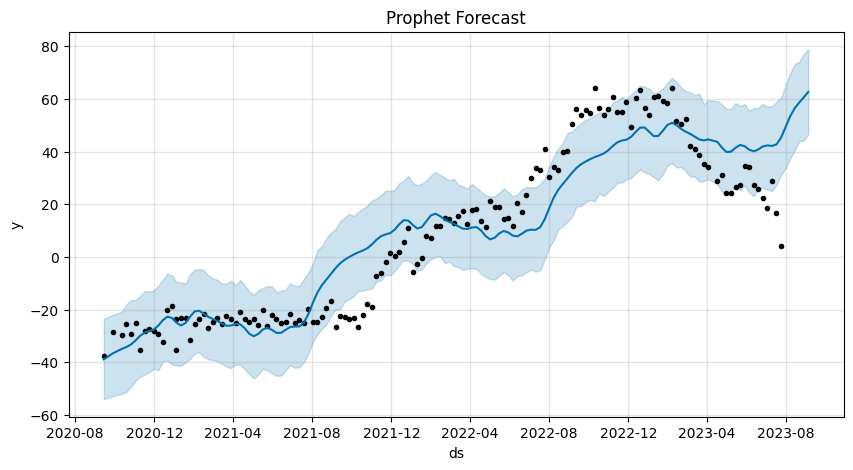

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst_future, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [19]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [20]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-6:].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
me     :  51.5999
rmse   :  51.9709
direction_accuracy :  0.6


In [21]:
future_yhat.index = df_test.index


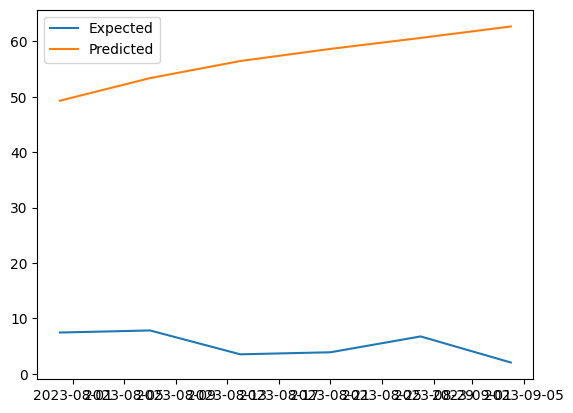

In [22]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

For walk-forward validation, just as before we train the model at every step of a loop where we append the training dataset with the newest step from the test data set and predict corresponding one-step at each stage to get a prediction list.

In [23]:
predictions = {}

In [27]:
for t in range(0,len(pjme_test_prophet)):
    print(t)

0
1
2
3
4
5


In [28]:
input = pjme_train_prophet #starting input as the original training dataset
for t in range(0,len(pjme_test_prophet)):
    model = Prophet() #Prophet requires an initialisation every time before fit
    model.fit(input) 
    future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
    pred_step = model.predict(future) # and get the prediction "row" for that one step
    # print(pred_step.iloc[-1:]['yhat']) 
    predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
    new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
    # print(new_obs['y']) 
    input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step


09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:47:03 - cmdstanpy - INFO - Chain [1] done processing
09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:47:03 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing


147    49.299807
Name: yhat, dtype: float64
7.458213826525567
148    45.757538
Name: yhat, dtype: float64
7.83274998784697
149    45.584571
Name: yhat, dtype: float64
3.525113215314945


09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing


150    39.603361
Name: yhat, dtype: float64
3.896402411881346
151    37.172494
Name: yhat, dtype: float64
6.754482645171904
152    44.092295
Name: yhat, dtype: float64
2.053264604810996


In [37]:
pred_step.head(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-14,-46.236301,-57.295670,-26.135470,-46.236301,-46.236301,4.862986,4.862986,4.862986,4.862986,4.862986,4.862986,0.0,0.0,0.0,-41.373315
1,2020-09-28,-44.721030,-55.309072,-23.915877,-44.721030,-44.721030,5.329993,5.329993,5.329993,5.329993,5.329993,5.329993,0.0,0.0,0.0,-39.391038
2,2020-10-12,-43.205759,-52.929989,-22.632771,-43.205759,-43.205759,5.617522,5.617522,5.617522,5.617522,5.617522,5.617522,0.0,0.0,0.0,-37.588237
3,2020-10-19,-42.448124,-52.115099,-21.570009,-42.448124,-42.448124,6.083340,6.083340,6.083340,6.083340,6.083340,6.083340,0.0,0.0,0.0,-36.364784
4,2020-10-26,-41.690489,-49.583764,-19.354945,-41.690489,-41.690489,6.511988,6.511988,6.511988,6.511988,6.511988,6.511988,0.0,0.0,0.0,-35.178501
5,2020-11-02,-40.932853,-48.726077,-18.322105,-40.932853,-40.932853,7.175649,7.175649,7.175649,7.175649,7.175649,7.175649,0.0,0.0,0.0,-33.757204
6,2020-11-09,-40.175218,-48.233062,-17.044288,-40.175218,-40.175218,8.066565,8.066565,8.066565,8.066565,8.066565,8.066565,0.0,0.0,0.0,-32.108654
7,2020-11-16,-39.417583,-46.721336,-14.331214,-39.417583,-39.417583,8.690802,8.690802,8.690802,8.690802,8.690802,8.690802,0.0,0.0,0.0,-30.726781
8,2020-11-23,-38.659947,-45.057267,-15.301939,-38.659947,-38.659947,8.756613,8.756613,8.756613,8.756613,8.756613,8.756613,0.0,0.0,0.0,-29.903334
9,2020-11-30,-37.902312,-44.622834,-13.238101,-37.902312,-37.902312,8.768075,8.768075,8.768075,8.768075,8.768075,8.768075,0.0,0.0,0.0,-29.134238


In [46]:
predictions = pred_step[-6:]['yhat']

In [47]:
predictions.index = pjme_test_prophet.index
predictions

date
2023-07-31    31.059974
2023-08-07    28.487436
2023-08-14    27.659631
2023-08-21    30.430859
2023-08-28    36.706402
2023-09-04    44.092295
Name: yhat, dtype: float64

In [49]:
pjme_test_prophet

,ds,y
date,,
2023-07-31,2023-07-31,7.458214
2023-08-07,2023-08-07,7.832750
2023-08-14,2023-08-14,3.525113
2023-08-21,2023-08-21,3.896402
2023-08-28,2023-08-28,6.754483
2023-09-04,2023-09-04,2.053265


In [50]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predictions, pjme_test_prophet['y'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
me     :  27.8194
rmse   :  28.6781
direction_accuracy :  0.6


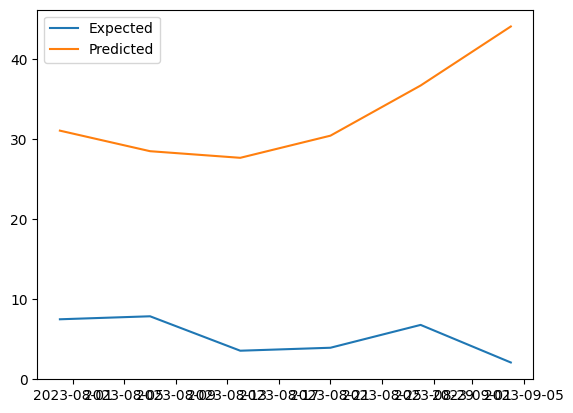

In [51]:
# plot expected vs preducted
plt.plot(pjme_test_prophet['y'], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()